# A simple CNN for the edge lover task

**Goal:** In this notebook you train a very simple CNN with only 1 kernel to discriminate images containing vertical from those containing horizontal stripes. To check what pattern is recognized by the learned kernel you will visualize the weights of the kernel as an image. You will see that the CNN leans a useful kernel (either a vertical or horiziontal bar).You can experiment with the code to check the influence of the kernel size, the activation function and the pooling method on the result.  

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.  

**Dataset:** You work with an artficially generatet dataset of greyscale images (50x50 pixel) with 10 vertical or horizontal bars. We want to classify them into whether or not an art lover will like them(0 or 1).  

**Content:**
* definig and generating the dataset X_train and X_val
* visualize samples of the generated images
* use keras to train a CNN with only one kernel (5x5 pixel)
* visualize the weights of the leaned kernel and interpret if it is useful
* repeat the last two steps to check if the learned kernel is always the same


| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/nb_ch02_03.ipynb)


#### Imports and image generator functions

In the next two cells, we load all the required libraries and functions. We define two functions to generate images with vertical and horizontal images. 

In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False


TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.1.0-rc1  running in colab?:  True


In [0]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

import tensorflow.keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras.utils import to_categorical 

### Defining functions to generate images 

Here we define the function to genere images with vertical and horizontal bars, the arguments of the functions are the size of the image and the nr of bars you want to have. The bars are at random positions in the image with a random length. The image is black and white, meaning we have only two values for the pixels, 0 for black and 255 for white.

In [0]:
#define function to generate image with shape (size, size, 1) with stripes
def generate_image_with_bars(size, bar_nr, vertical = True):
  img=np.zeros((size,size,1),dtype="uint8")
  for i in range(0,bar_nr):
    x,y = np.random.randint(0,size,2)
    l  = np.int(np.random.randint(y,size,1))
    if (vertical):
      img[y:l,x,0]=255
    else:
      img[x,y:l,0]=255
  return img  

Let's have a look how the generated images. We choose a size of 50x50 pixels and set the nr of bars in the image to 10. 

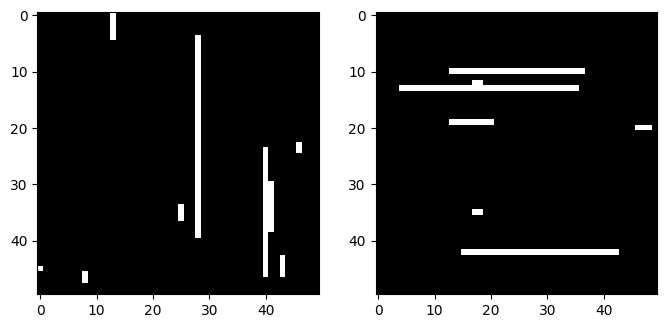

In [5]:
# have a look on two generated images
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
img=generate_image_with_bars(50,10, vertical=True)
plt.imshow(img[:,:,0],cmap='gray')
plt.subplot(1,2,2)
img=generate_image_with_bars(50,10, vertical=False)
plt.imshow(img[:,:,0],cmap='gray')

### Make a train and validation dataset of images with vertical and horizontal images
Now, let's make a train dataset *X_train* with 1000 images (500 images with vertical and 500 images with horizontal bars). We normalize the images values to be between 0 and 1 by dividing all values with 255. We create a secont dataste *X_val* with exactly the same properties to validate the training of the CNN.

In [6]:
pixel=50  # define height and width of images
num_images_train = 1000 #Number of training examples (divisible by 2) 
num_images_val = 1000 #Number of training examples (divisible by 2) 

# generate training data with vertical edges
X_train =np.zeros((num_images_train,pixel,pixel,1))
for i in range(0, num_images_train//2):
   X_train[i]=generate_image_with_bars(pixel,10)
# ... with horizontal
for i in range(num_images_train//2, num_images_train):
   X_train[i]=generate_image_with_bars(pixel,10, vertical=False)

# generate validation data 
X_val =np.zeros((num_images_train,pixel,pixel,1))
for i in range(0, num_images_train//2): 
   X_val[i]=generate_image_with_bars(pixel,10)
# ... with horizontal
for i in range(num_images_train//2, num_images_train):
   X_val[i]=generate_image_with_bars(pixel,10, vertical=False)


# normalize the data to be between 0 and 1
X_train=X_train/255
X_val=X_val/255

print(X_train.shape)
print(X_val.shape)

(1000, 50, 50, 1)
(1000, 50, 50, 1)


Here we make the labels for the art lover, 0 means he likes the image and 1 means that he doesn't like it. We convert the labels into the one hot encoding becuase we want to use two outputs in our network.

In [0]:
# create class labels
y = np.array([[0],[1]])
Y_train = np.repeat(y, num_images_train //2)
Y_val = np.repeat(y, num_images_train //2)

# one-hot-encoding
Y_train=to_categorical(Y_train,2)
Y_val=to_categorical(Y_val,2)

## Defining the CNN to predict which images the art lover likes

Here we define the kind of special architecture of the CNN: 

>we use only one kernel with a size of 5x5 pixels  
>then we apply a linar activation function  
>the maxpooling layer takes the maximum of the whole activation map to predict the probability (output layer with softmax) if the art lover will like the image

as loss we use the categorical_crossentropy and we train for 20 epochs with a batchsize of 64 images per update.


#### Listing 2.5 Edge lover CNN                                                                                                                      

In [0]:
model = Sequential()

model.add(Convolution2D(1,(5,5),padding='same',input_shape=(pixel,pixel,1)))
model.add(Activation('linear'))

# take the max over all values in the activation map
model.add(MaxPooling2D(pool_size=(pixel,pixel)))
model.add(Flatten()) 
model.add(Dense(2))
model.add(Activation('softmax'))

# compile model and initialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [9]:
# let's summarize the CNN architectures along with the number of model weights
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 1)         26        
_________________________________________________________________
activation (Activation)      (None, 50, 50, 1)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 1)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4         
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 30
Trainable params: 30
Non-trainable params: 0
____________________________________________________________

In [10]:
# train the model
history=model.fit(X_train, Y_train,
                  validation_data=(X_val,Y_val),
                  batch_size=64, 
                  epochs=50,
                  verbose=1,
                  shuffle=True) 

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.7168 - accuracy: 0.5000 - val_loss: 0.6959 - val_accuracy: 0.5000
Epoch 2/50
1000/1000 [==============================] - 0s 164us/sample - loss: 0.6787 - accuracy: 0.5000 - val_loss: 0.6612 - val_accuracy: 0.5000
Epoch 3/50
1000/1000 [==============================] - 0s 152us/sample - loss: 0.6467 - accuracy: 0.5000 - val_loss: 0.6320 - val_accuracy: 0.5000
Epoch 4/50
1000/1000 [==============================] - 0s 168us/sample - loss: 0.6193 - accuracy: 0.5000 - val_loss: 0.6071 - val_accuracy: 0.5000
Epoch 5/50
1000/1000 [==============================] - 0s 163us/sample - loss: 0.5962 - accuracy: 0.5000 - val_loss: 0.5869 - val_accuracy: 0.5000
Epoch 6/50
1000/1000 [==============================] - 0s 187us/sample - loss: 0.5777 - accuracy: 0.5000 - val_loss: 0.5696 - val_accuracy: 0.5000
Epoch 7/50
1000/1000 [==============================] - 0s 165us/s

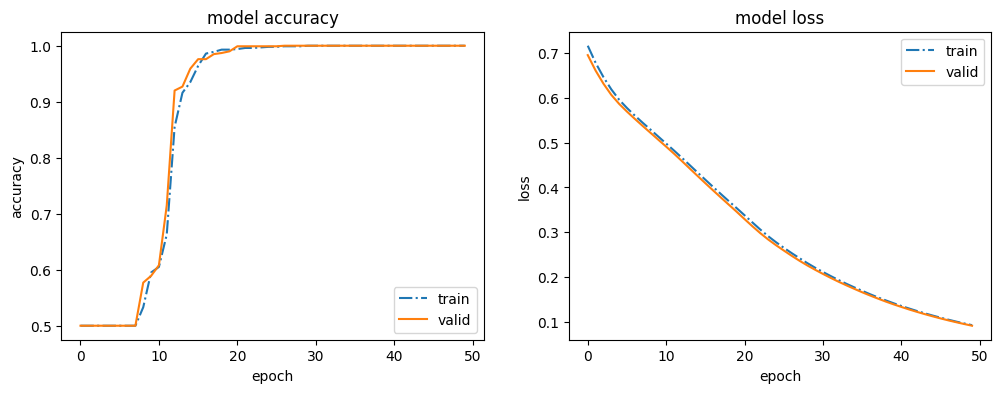

In [11]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

### Visualize the learned kernel and experiment with the code

You see that the CNN performs very good at this task (100% accuracy). We can check which pattern is recognized by the learned kernel and see if you think that this is helpful to distinguish between images with horizontal and vertical edges. 


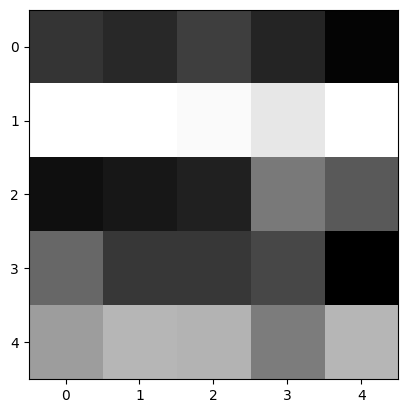

In [12]:
# get the leared weights and display them as image
conv_filter=model.get_weights()[0]
conv_filter.shape
conv_filter=np.squeeze(conv_filter, axis=2)
plt.imshow(conv_filter[:,:,0],"gray")

#### Repeat the training and exerpiment with the kernelsize and activation function.<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />
*Exercise: Repeat the compiling and training for several times and check if the CNN always learns the same kernel.  
You can experiment with the code and check what happens if you use another kernel size, activation function (relu instead of linear ) or pooling method AveragePooling instead of MaxPooling.  
Try to make a prediction before doing the experiment.*


